resources: get statevector (https://discuss.pennylane.ai/t/using-the-state-vector-directly/338/23) 





In [1]:
!pip install pennylane-sf --upgrade
!pip install qutip --upgrade
!pip install tensornetwork

Requirement already up-to-date: pennylane-sf in /usr/local/lib/python3.6/dist-packages (0.8.0)
Requirement already up-to-date: qutip in /usr/local/lib/python3.6/dist-packages (4.5.0)


In [0]:
import tensorflow as tf
import pennylane as qml
from pennylane.qnodes import PassthruQNode

import numpy as np
import scipy as sp

import qutip as qt
from qutip import Bloch, basis

In [0]:
dev = qml.device('default.qubit', wires=1)

def circuit(params, wires=0):
  qml.RX(params[0], wires=wires)
  qml.RY(params[1], wires=wires)

qnode = PassthruQNode(circuit, dev)

In [0]:
coeffs = [1, 1]
obs = [qml.PauliX(0), qml.PauliZ(0)]

H = qml.Hamiltonian(coeffs, obs)
qnodes = qml.map(circuit, obs, dev, measure='expval')
cost_fn  = qml.dot(coeffs, qnodes)

init_params = np.random.uniform(low=0, high=2*np.pi, size=2)

In [0]:
step_size = 0.01
max_iterations = 500
conv_tol = 1e-06
print_freq = 20

In [6]:
params = init_params
prev_energy = cost_fn(params)
qng_energies_block = []
all_states = []

for n in range(max_iterations):
    
    grad_cost = qml.grad(cost_fn, argnum=[0])
    grad_at_point = [float(i) for i in grad_cost(params)[0]] 
    
    params = params - step_size * np.dot(
                np.linalg.pinv(qnodes[0].metric_tensor([params])), 
                grad_at_point)

    energy = cost_fn(params)
    qng_energies_block.append(energy)
    
    conv = np.abs(energy - prev_energy)

    state_step = dev._state
    all_states.append(state_step)

    if n % print_freq == 0:
        print('Iteration = {:}'.format(n) ,'Energy = {:.8f} Ha,'.format(energy), 'Convergence parameter = {'
              ':.8f} Ha'.format(conv), "State", state_step)

    if conv <= conv_tol:
        qng_block_steps = n
        break

    prev_energy = energy

    state_final = dev._state

print()
print('Final value of the ground-state energy = {:.8f} Ha'.format(energy))
print()
print("Final state", state_final)
print()
print('Number of iterations = ', n)

Iteration = 0 Energy = -0.33138443 Ha, Convergence parameter = 0.07719372 Ha State [-0.31488936+0.22673415j  0.07774279+0.91836396j]
Iteration = 20 Energy = -1.25056604 Ha, Convergence parameter = 0.01887057 Ha State [-0.14881193-0.19686787j -0.03024606+0.96859859j]
Iteration = 40 Energy = -1.39737372 Ha, Convergence parameter = 0.00206566 Ha State [-0.04691507-0.3269044j -0.01625081+0.9437523j]
Iteration = 60 Energy = -1.41256477 Ha, Convergence parameter = 0.00020351 Ha State [-0.01448726-0.36551726j -0.00568979+0.93067442j]
Iteration = 80 Energy = -1.41405294 Ha, Convergence parameter = 0.00001984 Ha State [-0.00449969-0.37735071j -0.00183354+0.92605768j]
Iteration = 100 Energy = -1.41419792 Ha, Convergence parameter = 0.00000193 Ha State [-0.00140185-0.38102175j -0.00057772+0.92456483j]

Final value of the ground-state energy = -1.41420579 Ha

Final state [-0.00104755-0.38144169j -0.00043226+0.92439221j]

Number of iterations =  106


In [7]:
plot_states = []
lst = all_states[::10]

for i in range(len(lst)):
  psi = lst[i]
  psi = psi/np.linalg.norm(psi)

  # Convert to QObject in QuTiP
  coords = [qt.Qobj(psi)]

  plot_states.append(coords)

print(plot_states)

[[Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.31488936+0.22673415j]
 [ 0.07774279+0.91836396j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.24378252-0.04002743j]
 [-0.01007067+0.96895122j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.14881193-0.19686787j]
 [-0.03024606+0.96859859j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.08431057-0.28132391j]
 [-0.02482114+0.95557967j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.04691507-0.3269044j]
 [-0.01625081+0.9437523j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.02605199-0.35179785j]
 [-0.00979524+0.93566213j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.01448726-0.36551726j]
 [-0.00568979+0.93067442j]]], [Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[

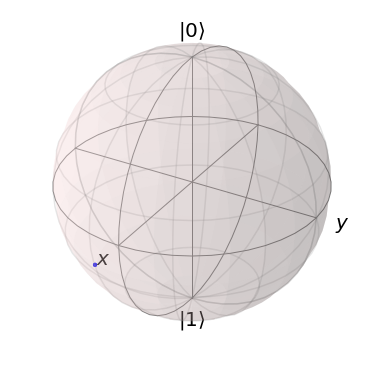

In [8]:
psi = all_states[0]
psi = psi/np.linalg.norm(psi)

# Convert to QObject in QuTiP
coords = [qt.Qobj(psi)]

# Settings for Bloch sphere visualization
pt_size = [10]*4
pt_marker = 'o'
pt_color = 'b'

bloch_plot = Bloch()
bloch_plot.point_marker = pt_marker
bloch_plot.point_color = pt_color
bloch_plot.point_size = pt_size

for coords in coords:
    bloch_plot.add_states(coords, 'point')

bloch_plot.show()

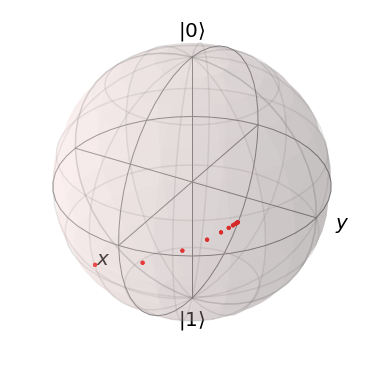

In [12]:
bloch_plot = Bloch()

# Settings for Bloch sphere visualization
pt_size = [10]*4
pt_marker = 'o'
pt_color = 'r'

bloch_plot = Bloch()
bloch_plot.point_marker = pt_marker
bloch_plot.point_color = pt_color
bloch_plot.point_size = pt_size

bloch_plot.add_states(plot_states, 'point')

bloch_plot.show()

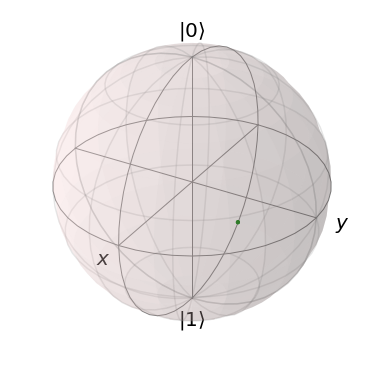

In [10]:
psi = state_final
psi = psi/np.linalg.norm(psi)

# Convert to QObject in QuTiP
coords = [qt.Qobj(psi)]

bloch_plot = Bloch()

# Settings for Bloch sphere visualization
pt_size = [10]*4
pt_marker = 'o'
pt_color = 'g'

bloch_plot = Bloch()
bloch_plot.point_marker = pt_marker
bloch_plot.point_color = pt_color
bloch_plot.point_size = pt_size

bloch_plot.add_states(coords, 'point')

bloch_plot.show()